# BCDATA Data Science Workshop

## Basic machine learning with scikit-learn

* [Machine learning terminology](#terminology)
* [Example: Hand-written digits](#digits)
* [Principal component analysis](#pca)
* [Our own PCA function](#our-pca)
* [K-means clustering](#clustering)
* [K-nearest neighborhors classification](#classification)

---

Patrick Walls

pwalls@math.ubc.ca

---

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

---

<a id='terminology'></a>
## Machine learning terminology

"Machine Learning" is a broad term applied to the practice of using data to create models and make predictions. Common machine learning problems include curve fitting, spam filtering, recommendation algorithms, image recognition, etc.

Machine learning problems generally fall into 2 categories:

* Supervised Learning (observed data includes labels)
  * Regression (to predict a continuous variable)
    * Salary versus years of work experience
    * House prices versus square footage
  * Classification (to predict a discrete variable)
    * Spam detection
    * Image recognition
    * Sentiment analysis
* Unsupervised Learning (observed data does not include labels)
  * Classify customers using some retail website
  * Recommendation algorithms (such as Netflix, Amazon, etc.)
  * Separate different voices given an audio recording of several people speaking simultaneously
  * Classify distant galaxies

Common machine learning terms:

* **Sample**: an element in the dataset represented as a numeric vector
* **Feature**: a value in the vector representing the sample
* **Label (or target)**: output value represented by a numeric vector attached to an input sample
* **Supervised Learning**: build a model on a set of samples with labels
    * **Classification**: target set is discrete
    * **Regression**: target set is continuous
* **Unsupervised**: set of samples does not labelled
    * **Dimension reduction**: map sample space to a space with fewer dimensions while retaining as much information as possible
    * **Clustering**: group samples into natural categories
* **Training and testing sets**: split the dataset into a training set used to build a model and a testing set used to test the model

<a id='digits'></a>
## Hand-written digits

[scikit-learn](http://scikit-learn.org/stable/) is a Pytho library for machine learning and comes with sample datasets for experimentation. We will do dimension reduction, clustering and classification on the digits dataset.

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

The dataset is loaded as an object and we can see its attributes using the builtin `dir` function:

In [4]:
dir(digits)

['DESCR', 'data', 'images', 'target', 'target_names']

Let's begin by looking at the description of the dataset:

In [5]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

`data`, `images` and `target` are NumPy arrays:

In [6]:
type(digits.data)

numpy.ndarray

In [7]:
digits.data.shape

(1797, 64)

In [8]:
type(digits.images)

numpy.ndarray

In [9]:
digits.images.shape

(1797, 8, 8)

In [10]:
type(digits.target)

numpy.ndarray

In [11]:
digits.target.shape

(1797,)

The arrays `data` and `images` contain the same data but in different shapes:

In [12]:
digits.data[0,:]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

In [13]:
digits.images[0,:,:]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]])

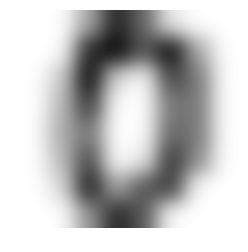

In [14]:
plt.imshow(digits.images[0,:,:],cmap='binary',interpolation='gaussian')
plt.axis('off')
plt.show()

And we verify that the first target value is 0:

In [15]:
digits.target[0]

0

<A id="pca"></a>
## Principal component analysis

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) is an algorithm for dimension reduction. Suppose the data is stored as rows in a matrix $X$ (normalized such that the mean value of each coordinate in the dataset is 0). We want to find a (unit) vector $w$ such that the projection of the dataset onto $w$ preserves as much information as possible. This means we want the sum of the lengths $\sum_i |X_i w|$ to be maximum (where $X_i$ is the $i$th row of $X$). We can write the sum of squares of the lengths of the projections as $|| X w ||^2 = | w^T X^T X w|$ therefore

$$
w = \text{argmax}_{||u|| = 1} \left\{ u^T X^T X u \right\}
$$

Finally, it's a [classical result](https://en.wikipedia.org/wiki/Rayleigh_quotient) that the maximum occurs when $u$ is the eigenvector corresponding to the maximum eigenvalue of $X^TX$.

Therefore the PCA algorithm is:

1. Normalize the matrix $X$ so that the mean value in each column is 0.
2. Find the $n$ (unit) eigenvectors $w_1, \dots, w_n$ corresponding to the $n$ largest eigenvalues of $X^T X$.

We'll start by using the PCA class in scikit-learn to project the digits dataset to 2D and then we'll write our own PCA function.

In [16]:
from sklearn.decomposition import PCA

`PCA` is a class and we instantiate a new PCA object and specifiy the number of principal components we want to find in the data:

In [17]:
pca = PCA(n_components=2)

Now we simply call the fit method and our `PCA` object computes the first 2 principal components:

In [18]:
pca.fit(digits.data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

We can look at the principal components:

In [19]:
pca.components_.shape

(2, 64)

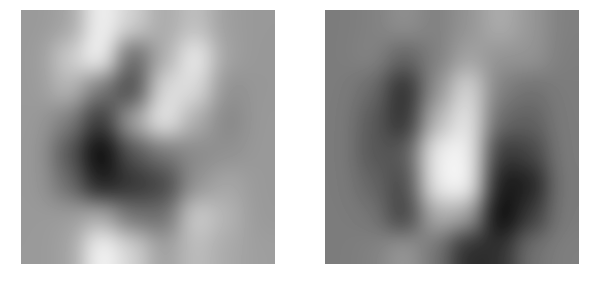

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1), plt.axis('off')
plt.imshow(pca.components_[0,:].reshape(8,8),cmap='binary', interpolation='gaussian')
plt.subplot(1,2,2), plt.axis('off')
plt.imshow(pca.components_[1,:].reshape(8,8),cmap='binary', interpolation='gaussian')
plt.show()

Finally, we project our dataset onto the principal components using the `transform` method:

In [21]:
data2D = pca.transform(digits.data)

Plot the digits in 2D as a scatter plot with the color of each sample given by its label:

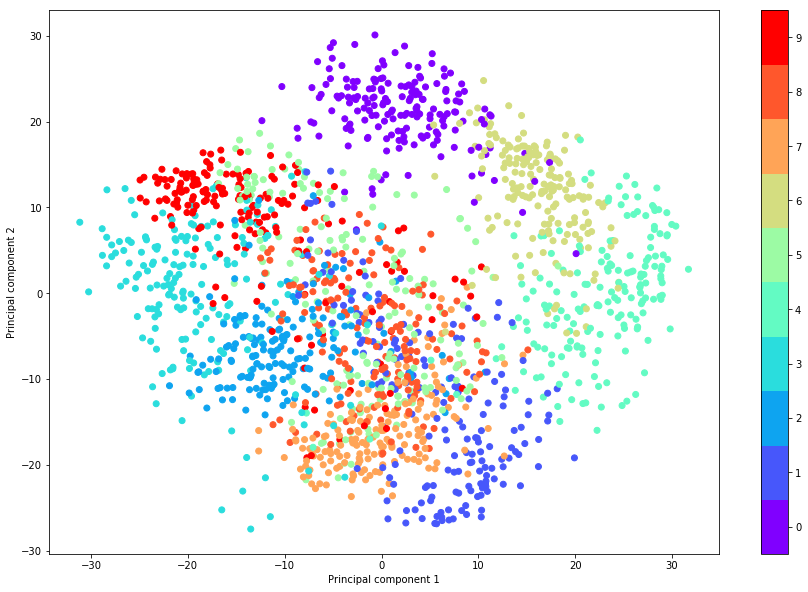

In [22]:
discrete_colors = matplotlib.cm.get_cmap('rainbow',10)
plt.figure(figsize=(15,10))
plt.scatter(data2D[:,0],data2D[:,1],c=digits.target,cmap=discrete_colors,vmin=-0.5,vmax=9.5)
plt.colorbar(ticks=np.arange(0,10))
plt.xlabel('Principal component 1'), plt.ylabel('Principal component 2')
plt.show()

Suppose we wanted to see the first 5 principal components:

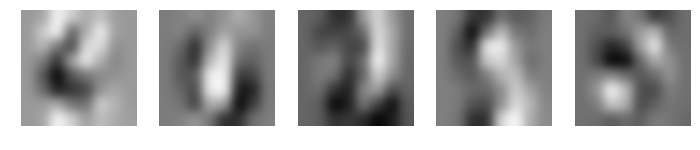

In [23]:
pca5 = PCA(n_components=5)
pca5.fit(digits.data)
plt.figure(figsize=(12,4))
plt.subplot(1,5,1)
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(pca5.components_[i,:].reshape(8,8),cmap='binary',interpolation='gaussian')
    plt.axis('off')

<a id='our-pca'></a>
## Our own PCA function

Let's write a function which takes input parameters `data` and `n_components` and returns the first $n$ principal components of the data.

In [24]:
import scipy.linalg as la

In [25]:
def myPCA(data,n_components):
        
    # Normalize the data
    means = data.mean(axis=0)
    data = data - means
    
    # Find the eigenvalues of X^T X
    evals, evecs = la.eig(data.T @ data)
    
    # Find the n largest eigenvalues
    indices = np.argsort(evals.real)[::-1][:n_components]
    pc = evecs[:,indices].real.T
        
    return pc

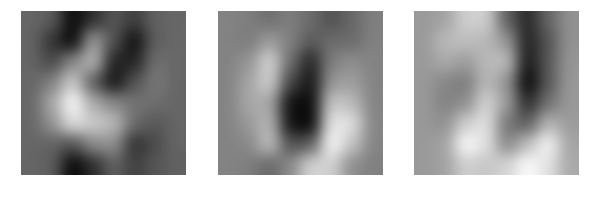

In [26]:
N = 3
pc = myPCA(digits.data,N)
plt.figure(figsize=(10,6))
plt.subplot(1,N,1)
for i in range(0,N):
    plt.subplot(1,N,i+1)
    plt.imshow(pc[i,:].reshape(8,8),cmap='binary',interpolation='gaussian')
    plt.axis('off')

<a id='clustering'></a>
## K-means clustering

How many different kinds of ones are there?

Use fancy indexing to get all the ones in the dataset:

In [27]:
ones = digits.data[digits.target == 1]

In [28]:
ones.shape

(182, 64)

There are 182 samples of the digit 1. Let's project this set to 2D to see the distribution of ones:

In [29]:
ones2D = pca.transform(ones)

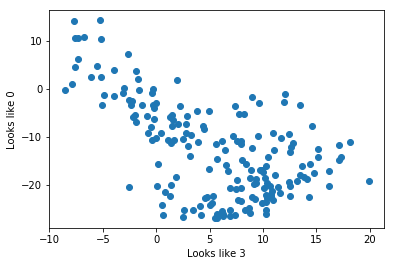

In [30]:
plt.scatter(ones2D[:,0],ones2D[:,1])
plt.xlabel('Looks like 3')
plt.ylabel('Looks like 0')
plt.show()

Let's look at the two samples which are far apart:

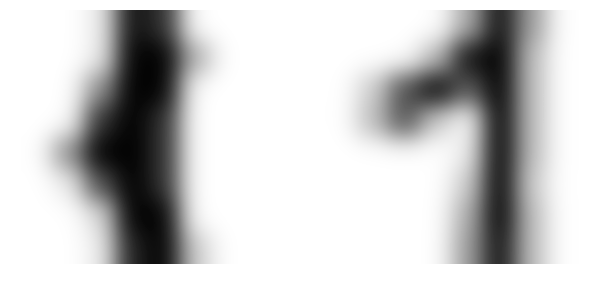

In [31]:
index1 = ones2D[:,0].argmax()
outlier1 = ones[index1,:]
index2 = ones2D[:,1].argmax()
outlier2 = ones[index2,:]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(outlier1.reshape(8,8),cmap='binary',interpolation='gaussian')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(outlier2.reshape(8,8),cmap='binary',interpolation='gaussian')
plt.axis('off')
plt.show()

Now let's use k-means clustering to find cluster centers in the ones subset:

In [32]:
from sklearn.cluster import KMeans

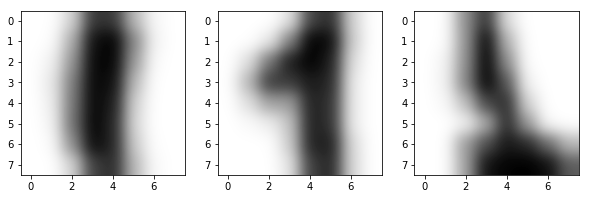

In [33]:
N = 3

clf = KMeans(n_clusters=N)
clf.fit(ones)

plt.figure(figsize=(10,6))
plt.subplot(1,N,1)

for i in range(0,N):
    plt.subplot(1,N,i+1)
    plt.imshow(clf.cluster_centers_[i,:].reshape(8,8),cmap='binary',interpolation='gaussian')

plt.show()

<a id='classification'></a>
## K-nearest neighbors classification

The simplest classification algorithm is $k$-nearest neighbors. The idea is that each sample is a point in the sample space. Given a new sample, we look at the labels of the $k$ nearest samples in the sample space and use this label to classifiy the new sample.

First, let's split our dataset into a training set to build the model with, and a a testing set to evaluate our model:

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
data_train, data_test,target_train, target_test = train_test_split(digits.data,digits.target,train_size=0.75)

Now it's as simple as fit, predict and score:

In [36]:
from sklearn.neighbors import KNeighborsClassifier as KNC

In [37]:
clf = KNC(n_neighbors=5)

In [38]:
clf.fit(data_train,target_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [39]:
clf.score(data_test,target_test)

0.99555555555555553

Looking at the confusion matrix, it seems that 9s are the most difficult to classify correctly:

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
y_pred = clf.predict(data_test)

In [42]:
confusion_matrix(y_pred,target_test)

array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 40,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0, 45,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 53,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 49,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 35,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 41,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 51,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 42,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 48]])